In [59]:
# import lib
# ===========================================================
import csv
import pandas as pd
from datascience import *
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

In [60]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value="null")
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

In [61]:
# Decision stump part for Adaboost
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, training_attribute, training_data, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # === when raising a question ===
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # Divide rows according to the question to true_rows and false_rows
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null" or not isinstance(ref_value, str) and np.isnan(ref_value): continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
    
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain, q = self.find_best_question(rows)
        if gain <= 0.01:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")
    
    def test(self):
        for i in range(self.column_num):
            q = self.Question(i, self.train[1][i], self.attribute)
            print(q)
            print(q.match(1))
    
def bootstrapped_dataset(rows):
    n = len(rows)
    bootstrapped_rows = []
    rand_idx = np.random.choice(n, n)
    for i in rand_idx:
        bootstrapped_rows.append(rows[i])
    return bootstrapped_rows

In [62]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [71]:
# Training Random Forest
# ===========================================================
rand_attribute_subset_len = 20

random_forest = []
start = time.time()

for i in range(10):
    rand_attribute_subset = np.random.choice(a=training_attribute, size=rand_attribute_subset_len)
    training_data = bootstrapped_dataset(training_data)
    tree = DecisionTree(rand_attribute_subset, training_data, "CART")
#     tree.print_tree(tree.root)
    random_forest.append(tree)
end = time.time()
print("Random Forest Trained! Time: %.03fs" % (end - start))

Random Forest Trained! Time: 9.546s


In [72]:
# Testing Random Forest, Computing TN, TP, FN, FP, etc.
# ===========================================================

ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
forest_size = len(random_forest)
CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
for cutoff in np.arange(0, 1 + step_size, step_size):
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        true_rate_forest = 0
        for tree_i in random_forest:
            
            # prediction is a counter of label 1 and 0
            pred_counter = tree.classify(row, tree.root)
            true_rate_tree = pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001)
            true_rate_forest += true_rate_tree
        true_rate_forest /= forest_size
        true_pred = 1 if true_rate_forest >= cutoff else 0
        indicator = (true_pred << 1) + row[-1]
        
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
        
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))

In [73]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR
0,0,0,48268,16269,0.252088,1,1
0.05,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.1,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.15,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.2,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.25,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.3,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.35,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.4,44819,15114,3449,1155,0.712367,0.0709939,0.0714552
0.45,44819,15114,3449,1155,0.712367,0.0709939,0.0714552


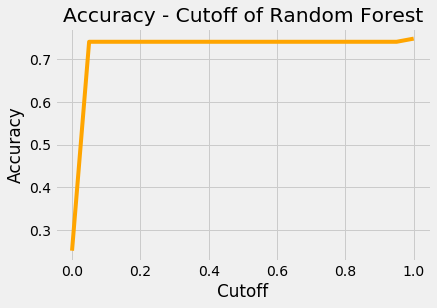

In [66]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Random Forest')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.show()
fig.savefig('Random Forest ACC.png', bbox_inches='tight')

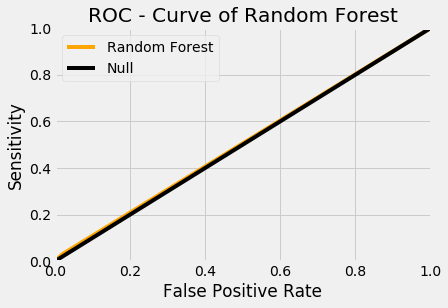

In [67]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Random Forest')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.legend(['Random Forest', 'Null'])
plt.axis([0, 1, 0, 1])
plt.show()
fig.savefig('Random Forest ROC.png', bbox_inches='tight')

In [35]:
# Original Testing Random Forest
# ===========================================================
forest_acc = []
for tree_i in random_forest:
    accuracy = []
    for row in training_data:
        classification = tree_i.classify(row, tree_i.root)
        if len(classification) == 1:
    #         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
            accuracy.append(int(classification.get(row[-1], 0) > 0))
        else:
    #         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
            tot = sum(classification.values())
            accuracy.append(classification.get(row[-1], 0) / tot)
    forest_acc.append(sum(accuracy) / len(accuracy))
print(np.average(forest_acc))
end = time.time()
print("time = %.03fs" % (end - start))

0.8288292241411295
time = 131.254s


In [55]:
# sklearn lib version
# ===========================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
df = pd.read_csv('clinvar_conflicting_mapped.csv', low_memory=False)
df.head()
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [56]:
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
X = [row[: -1] for row in training_data]
Y = [row[-1] for row in training_data]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, Y)

/Users/frostace/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [57]:
test = [row[: -1] for row in testing_data]
actual_label = [row[-1] for row in testing_data]
result = clf.predict(test)

In [58]:
accuracy = 0
for i in range(len(result)):
    accuracy += int(result[i] == actual_label[i])
accuracy /= len(result)
accuracy

0.7480670003253947